# Final Report

### Introduction
Heart disease is a leading cause of death worldwide (Roth., et al, 2020). It is a series of conditions including irregular heartbeats, vascular disease (e.g. coronary artery disease), etc (Tsao., et al, 2022). In addition, the effects of heart disease may differ between sexes (Di Fusco., et al, 2014). In this study, we explore whether there is a difference in heart rate between males and females.

Our dataset comes from a database studying heart disease with 76 attributes, filtered down to 14. The dataset was compiled in 1988 as four regional subsets: Cleveland, Hungary, Switzerland, and VA Long Beach. We will only be looking at two variables: sex and maximum heart rate.


# Methods and Results

First, we import our dataset, tidy it, and select our variables. We also renamed the sex values for better readability.

In [37]:
library(infer)
library(tidyverse)

In [38]:
# here we import each regional subset, and make an additional variable of "region"
cl <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header = FALSE) %>%
    mutate(region = "CL")
hg <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", header = FALSE) %>%
    mutate(region = "HA")
va <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", header = FALSE) %>%
    mutate(region = "VA")
sw <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", header = FALSE) %>%
    mutate(region = "SW")

# here we merge all four subsets together, and select the needed variables, and rename them for readibility
data <- rbind(cl, hg, va, sw) %>%
    select(V2, V8) %>%
    rename(sex = V2, max_heart_rate = V8) %>%
    mutate(max_heart_rate = as.numeric(max_heart_rate)) %>%
    filter(!is.na(max_heart_rate))

# we also changed max_heart_rate to be reported in double rather than as char, and filtered out the N/A values

# here we renamed the sex categories from integers to readable text

data$sex[data$sex == 1] <- "Male"
data$sex[data$sex == 0] <- "Female"

# viewing a snippet of our data
head(data)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


,sex,max_heart_rate
,<chr>,<dbl>
1,Male,150
2,Male,108
3,Male,129
4,Male,187
5,Female,172
6,Male,178


Now, we visualize our data. We chose two histograms comparing the maximum heart rate across the sexes.

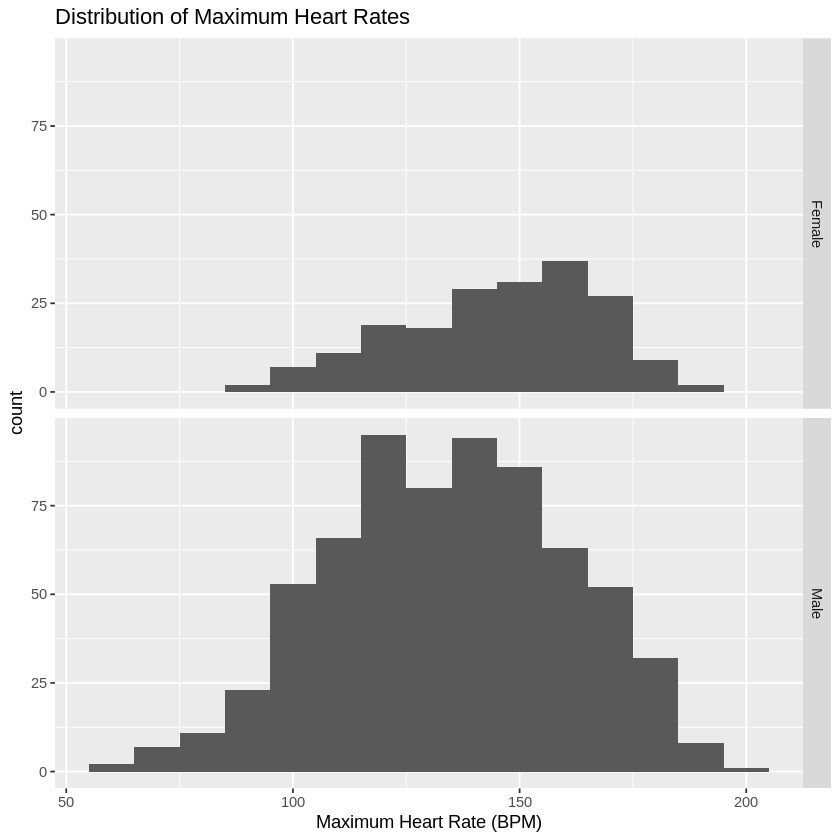

In [39]:
set.seed(200)
max_heart_rate_hist <- data %>%
                        ggplot() + 
                        geom_histogram(aes(x = max_heart_rate), binwidth = 10) +
                        ggtitle("Distribution of Maximum Heart Rates") +
                        facet_grid(sex ~ .) +
                        xlab("Maximum Heart Rate (BPM)")
max_heart_rate_hist

We estimate our parameter by finding the mean max heart rate of each sex and then finding the difference between them.

In [40]:
# here we find the sample mean of max heart rate among each sex
set.seed(201)
means <- data %>%
    group_by(sex) %>%
    summarise(mean = mean(max_heart_rate))

# here we find the sample difference in means between the two sexes
p_estim <- means %>%
    pivot_wider(names_from = "sex", values_from = "mean") %>%
    mutate(Diff = abs(Female - Male))

p_estim

Female,Male,Diff
<dbl>,<dbl>,<dbl>
146.2448,135.0639,11.1809


Our sample difference in means of max heart rate across the sexes is 11.18 bpm. We can visualize this in a density graph with the mean of each sex highlighted.

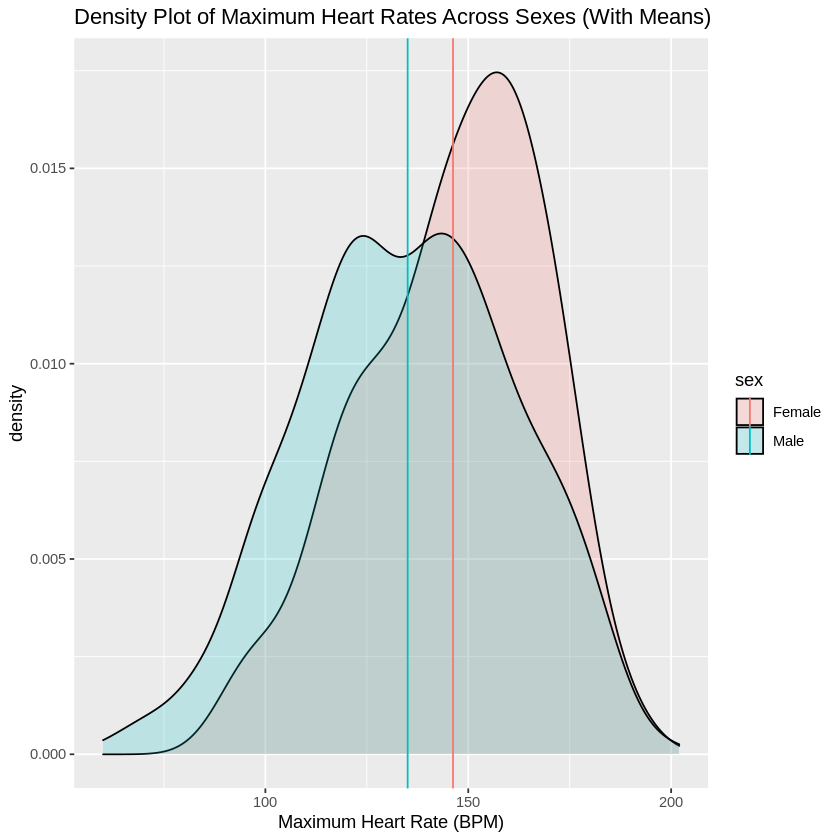

In [41]:
set.seed(202)

max_heart_rate_density_plot <- data %>%
    ggplot(aes(x = max_heart_rate, fill = sex)) + 
    geom_density(alpha = 0.2) +
    labs(x = "Maximum Heart Rate (BPM)",
         title = "Density Plot of Maximum Heart Rates Across Sexes (With Means)") +
    geom_vline(data = means, aes(xintercept = mean, color = sex), size = 0.5)

max_heart_rate_density_plot

### Comparing the Means of Two Independent Populations: `two-sample t-test`

Again, our parameter estimate is only based on our one sample, and is not representative of the population. Therefore, we cannot just base our conclusions for the population based on our parameter estimate. To produce more accurate approximations, it is practical to use a theory-based hypothesis test. We will be performing the hypothesis test at a **5% significance level**.

First, let's compare the distribution of the 2 sexes. A nice way to do this is by using Boxplots.


Female,Male,Diff
<dbl>,<dbl>,<dbl>
146.2448,135.0639,11.1809


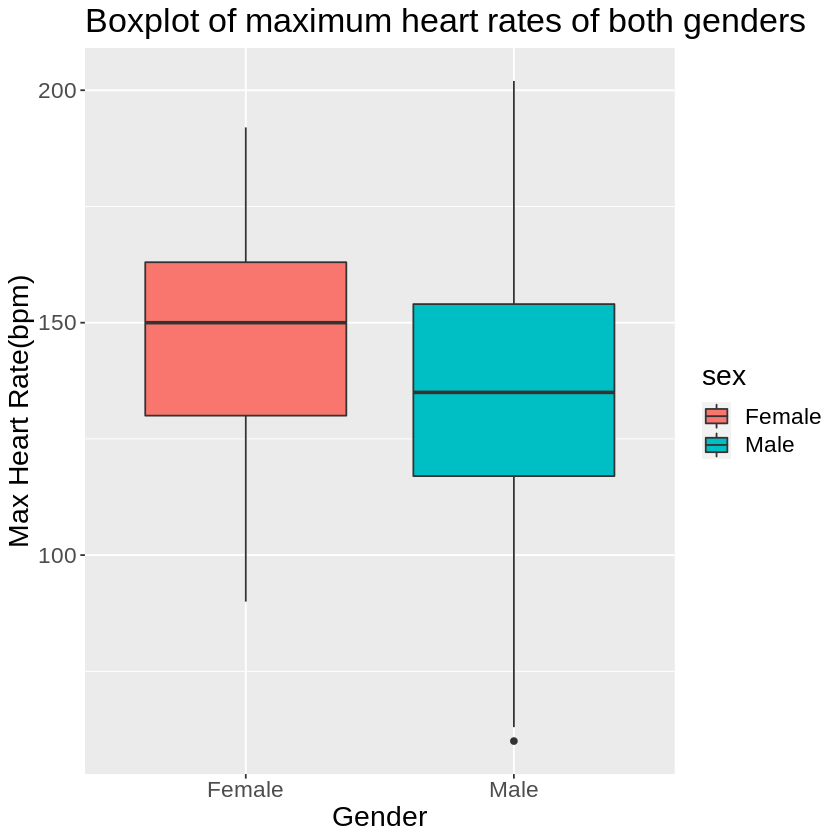

In [7]:
set.seed(250)

max_heart_rate_boxplots <-
    data %>% 
    ggplot() +
    geom_boxplot(aes(sex, max_heart_rate, fill = sex)) +
    theme(text = element_text(size = 17)) +
    ggtitle("Boxplot of maximum heart rates of both genders") + 
    xlab("Gender") + 
    ylab("Max Heart Rate(bpm)") #+ 
   # guides(fill = FALSE)

max_heart_rate_boxplots
p_estim

As expected, the boxplot indicates that Females have slightly higher maximum heart rates which complements the sample mean maximum heart rates calculated. But we should keep in mind that we only have a sample and not all existing individuals.

To answer the question, we will test the following hypotheses:
$$H_0: \mu_{\text{Female}} - \mu_{\text{Male}} = 0$$ $$H_1: \mu_{\text{Female}} - \mu_{\text{Male}} \neq 0$$
using the following test statistic:
$$
T = \frac{\bar{x}_{\text{Female}} - \bar{x}_{\text{Male}}}{\sqrt{\frac{s^2_{\text{Female}}}{n_1}+\frac{s^2_{\text{Male}}}{n_2}}}
$$
where $\bar{x}_{\text{Female}}$ and $\bar{x}_{\text{Male}}$ are the sample means of maximum heart rates for Females and Males, respectively; $s^2_{\text{Female}}$ and $s^2_{\text{Male}}$ are the sample variances for Females and Males, respectively; and $n_1$ and $n_2$ are the sample size for Females and Males, respectively. 


In [8]:
set.seed(251)
avg_f_mhr <- p_estim$Female # sample mean of female max heart rate
avg_m_mhr <- p_estim$Male   # sample mean of male max heart rate 

var_data <- data %>%
    group_by(sex) %>%
    summarise(var = sd(max_heart_rate)^2)   # calculate the sample variances

var_f_mhr <- var_data$var[1]  # sample variance of female max heart rate
var_m_mhr <- var_data$var[2]  # sample variance of male max heart rate

num_data <- data %>%
    group_by(sex) %>%
    summarise(count = n())   # calculate num of observations for each gender

n_f <- num_data$count[1]  # sample count of females
n_m <- num_data$count[2]  # sample count of males

t_stat <- (avg_f_mhr - avg_m_mhr)/sqrt(var_f_mhr/n_f + var_m_mhr/n_m)
var_f_mhr
var_m_mhr
n_f
n_m
t_stat

[1] 492.5314

[1] 696.4409

[1] 192

[1] 673

[1] 5.892771

Assuming $H_0$ : $\mu_{\text{Female}} = \mu_{\text{Male}}$ is true, the $T$ statistic follows a $t$ distribution with approximately
$$
\nu = \frac{
    \left(\frac{s_{Female}^2}{n_1}+\frac{s_{Male}^2}{n_2}\right)^2
}
{
\frac{s_{Female}^4}{n_1^2(n_1-1)}+\frac{s_{Male}^4}{n_2^2(n_2-1)}
}
$$
degrees of freedom.

In [9]:
set.seed(252)
v = (var_f_mhr/n_f + var_m_mhr/n_m)^2/(var_f_mhr^2/(n_f^2*(n_f-1)) + var_m_mhr^2/(n_m^2*(n_m-1)))   # calculate the degrees of freedom

v

[1] 359.5506

Obtaining the p-value for this hypothesis test using the approximation v

In [10]:
set.seed(253)
p_val <-2*pt(t_stat, df = v, lower.tail = FALSE)

p_val

[1] 8.740771e-09

Since the p-value is 8.7407707827024e-09 we can reject the null hypothesis at a 5% signficance level.

**Confidence interval** 

Calculating the 95% confidence interval for the difference in means of the maximum heart rate of females and males

In [11]:
set.seed(253)
data_diffmean_ci <- tibble(
    lower_ci = (avg_f_mhr - avg_m_mhr) + qt(0.025, df = v) * sqrt(var_f_mhr/n_f + var_m_mhr/n_m),
    upper_ci = (avg_f_mhr - avg_m_mhr) + qt(0.975, df = v) * sqrt(var_f_mhr/n_f + var_m_mhr/n_m))

data_diffmean_ci

lower_ci,upper_ci
<dbl>,<dbl>
7.449518,14.91228


Based on this interval estimation if we had to take 100 samples and estimate the difference between the female and male maximum heart rate, 95 of the 100 differences calculated would lie in the interval calculated above. However, the interval is wider because we are using the sample variance and sample mean to estimate it. Therefore there is more uncertainty.  

In [12]:
t_test <- 
    broom::tidy(
        t.test(x = filter(data, sex == "Female")$max_heart_rate,
               y = filter(data, sex == "Male")$max_heart_rate,
               alternative = "two.sided"))
t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
11.1809,146.2448,135.0639,5.892771,8.740771e-09,359.5506,7.449518,14.91228,Welch Two Sample t-test,two.sided


### Using Repeated Sampling to Perform Hypothesis Test and Get Confidence Interval

#### Hypothesis Test (Using Permutation)
Another way we can perform hypothesis testing is through permutations, which is a form of resampling without replacement. We use permutation to create a distribution of values that estimate the population distribution if the null hypothesis is true. This is what we call the null model.

In [31]:
set.seed(6)

# using permutation to make a null model

null_model <- data %>% 
   specify(formula = max_heart_rate ~ sex) %>% 
   hypothesize(null = "independence") %>% 
   generate(reps = 1000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("Female", "Male"))

head(null_model)

replicate,stat
<int>,<dbl>
1,0.6508946
2,-2.0669577
3,1.6684157
4,0.5237045
5,-0.2193536
6,-2.2543957


Like last time, we will be performing hypothesis testing at a $5\%$ significance level. This time, our test statistic is just our sample statistic: we don't need to alter it since our goal is to see if it's ever possible to get a sample with that test statistic in a world where the null hypothesis is true.

In [32]:
# our sample statistic (we can take this from our preliminary calculations)
obs_mean_diff <- p_estim %>% pull(Diff)
obs_mean_diff

[1] 11.1809

Now, we can see where our sample mean lies compared to the null distribution through a visuallization:

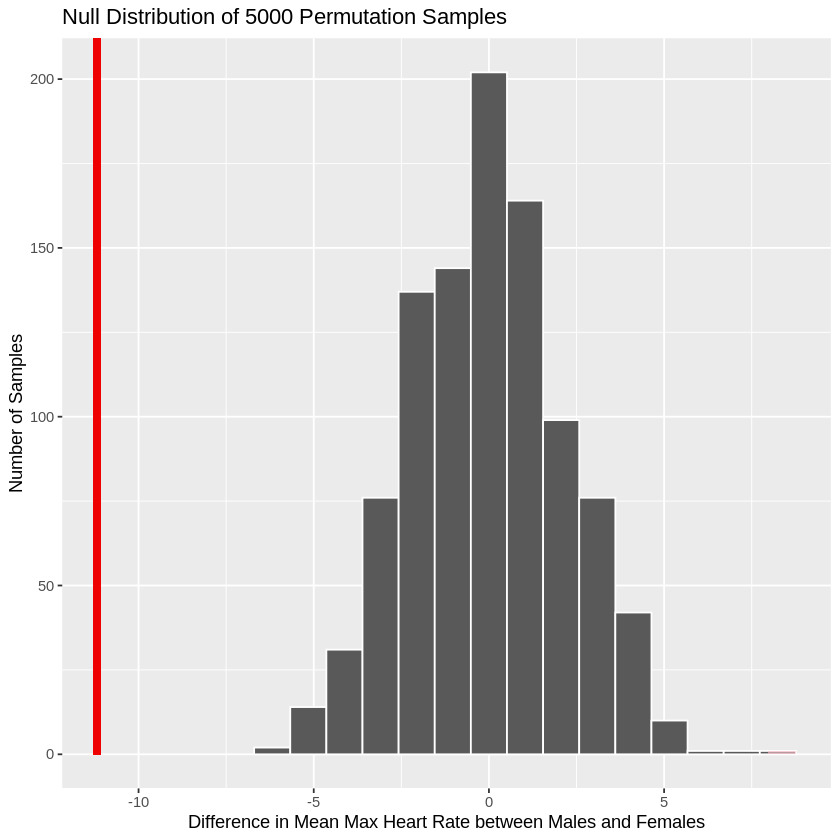

In [35]:
# see where our sample statistic lies on the null distribution
results_plot <- null_model %>%
   visualize() + 
   shade_p_value(obs_stat = obs_diff_means, direction = "both") +
   labs(x = "Difference in Mean Max Heart Rate between Males and Females",
        y = "Number of Samples", title = "Null Distribution of 5000 Permutation Samples")

results_plot

It's quite far off! It seems like there's practically no chance at all for us to ever be able to get a sample with the same value as our sample statistic if the null hypothesis is true. We can quantify this probability by calculating our p-value:

In [36]:
# our p_value
p_val <- null_model %>%
    get_p_value(obs_stat = obs_mean_diff, direction = "both") %>%
    pull(p_value)
p_val

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] 0

Uh-oh, we have calculated a p-value of $0$. We can't actually claim that our $p\text{-}value$ is $0$ though since that would be claiming that we have no chance of making a type I error. However, since we did 5000 permuted repetitions, we can claim that our $p\text{-}value$ is less than $\frac{1}{5000}$ (since less than 1 of our 5000 samples had that mean). Thus, we can say that our $p\text{-}value < \frac{1}{5000}$ or that our $p\text{-}value < 0.0002$.

Therefore, at the $5\%$ significance level, we **reject** the null hypothesis, as our $p\text{-}value < 0.0002 < 0.05$.

#### Confidence Interval (Using Bootstrapping)

In [20]:
set.seed(6)

# create 1000 bootstrap samples and calculate their sample statistics
bootstrap_samples <- data %>%
    rep_sample_n(nrow(data), reps = 1000, replace = TRUE) %>%
    group_by(replicate) %>%
    summarise(f_mean = mean(max_heart_rate[sex == "Female"]),
              m_mean = mean(max_heart_rate[sex == "Male"])) %>%
    group_by(replicate) %>%
    summarise(diff = f_mean - m_mean)

head(bootstrap_samples)

replicate,diff
<int>,<dbl>
1,12.634601
2,9.085475
3,13.640645
4,10.570741
5,14.233631
6,11.842065


In [21]:
# get the 95% confidence interval using the bootstrap distribution formed from our samples
bootstrap_ci <- bootstrap_samples %>%
    get_ci(level = 0.95)
bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
7.474879,15.04523


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



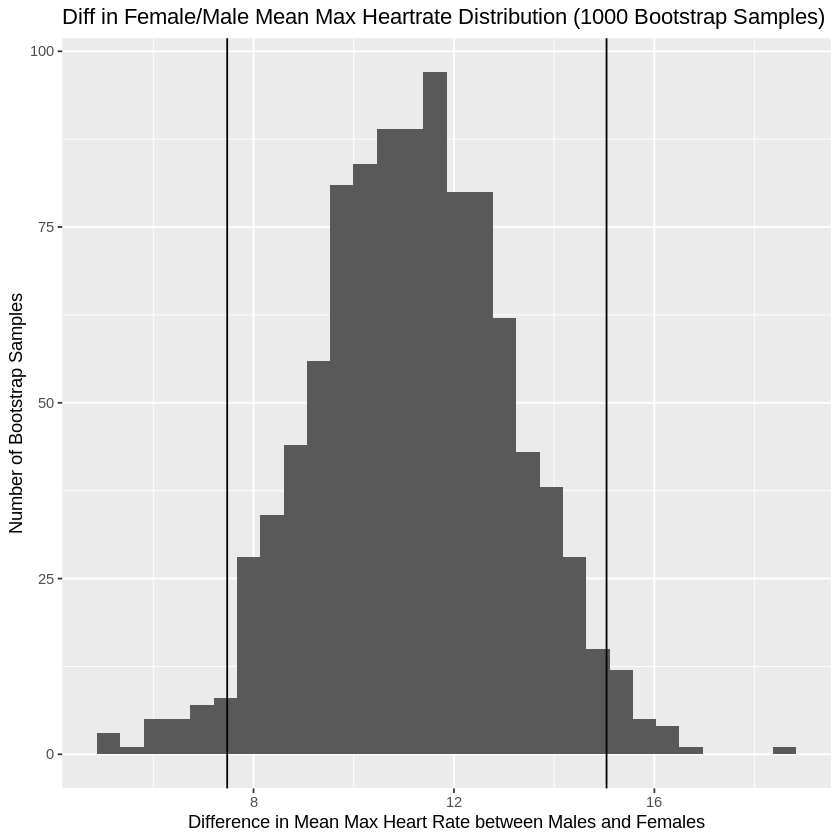

In [22]:
# visualise the bootstrap distribution and where the 95% confidence interval is

bootstrap_dist <- bootstrap_samples %>%
    ggplot(aes(x = diff)) +
    geom_histogram() +
    labs(x = "Difference in Mean Max Heart Rate between Males and Females",
     y = "Number of Bootstrap Samples",
     title = "Diff in Female/Male Mean Max Heartrate Distribution (1000 Bootstrap Samples)") +
    geom_vline(data = bootstrap_ci, aes(xintercept = lower_ci), size = 0.5) +
    geom_vline(data = bootstrap_ci, aes(xintercept = upper_ci), size = 0.5)

bootstrap_dist

# Discussions

# References